<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-Isaias-Hernandez/blob/main/Sep29-30/MCMC_Metropoli_30_08_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Markov Chain Metropolis algorithm

Por Isaias Hernández Lares

Draw random samples of the free parameters and accept then or reject them according to the posterior until you reach a maximum of the posterior.

1. Define an initial value of the free parameters.
2. Draw a new random sample of the free parameters from a gaussian distribution centered at the initial values, and with a predefined dispersion.
3. Evaluate the (logarithm) posterior of the initial parameters and that of the proposed parameters and compare them.
  - if the posterior of the porposal is higher than the (logarithm) posterior of the initial parameters accept the proposal and save it.
  - if the (logarithm) posterior of the proposal is lower than the (logarithm) posterior of the initial parameters then generate a random numbr between cero and one, if the radio of the (logarithm) posterior of the proposal and the initial parameter is larger than such number then you accepted the proposal and save it, if not you discard the proposal and keep the initial value.
4. If the porposal was accepted, replace the initial value by such proposal, if not keep the initial sample and repeat step 3.

After many steps, look at the resultant distribution (the chains) of parameters, i.e., the likelihood/posterior

In [165]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pdb
from matplotlib.gridspec import GridSpec

In [166]:
#Cargar datos
datos = np.loadtxt("/content/drive/MyDrive/ML2023/olympic100m_men.txt", delimiter=",")
datos_x = datos[:, 0]
datos_y = datos[:, 1]
#Normalizacion
datos_x_norm = (datos_x - np.mean(datos_x))/(np.std(datos_x))

-----------------------------------
Definiendo las funciones de likelihood, prior, posterior en su forma logaritmica

Posterior:
$$lnP \propto ln L + lnPr$$

Likelihood:
$$ ln L \propto -Σ_{i}\left(y_{i} - Model(x_{i},\vec{w})\right)^2-2 σ{i}^{2}$$

In [ ]:
#Modelo
def Modelo(x, theta):
  y = theta[0] + theta[1]*x
  return y

#Para evaluar el likelihood
def Log_Likelihood(x, y, theta, modelo):
  likelihood = -0.5 * np.sum((y - modelo(x, theta))**2)
  return likelihood

#Para evaluar el prior
def Log_Prior(theta, theta_min, theta_max):
  prueba = 1
  for i in range(len(theta)):
    if theta[i] < theta_min[i] or theta[i] > theta_max[i]:
      prueba *= 0
  if prueba == 1:
    prior = 0
  else:
    prior = -np.inf
  return prior

#Para evaluar el posterior
def Log_Posterior(x, y, theta, modelo, theta_min, theta_max):
  likelihood = Log_Likelihood(x, y, theta, modelo)
  prior = Log_Prior(theta, theta_min, theta_max)
  posterior = likelihood + prior
  return posterior

Log_Likelihood(datos_x_norm, datos_y, [31, .1], Modelo)

-5739.643721890537

----------------------
Definiendo la función del método MCM Metropoli

In [206]:
def Metropoli(x, y, iteraciones, modelo, theta_i, theta_min, theta_max, sigma_pendiente, sigma_ordenada, Log_Likelihood, Log_Prior, Log_Posterior):
  theta_inicial = theta_i
  np.random.normal(theta_inicial[0], sigma_ordenada)
  registro_aceptadas = []
  registro_rechazadas = []
  registro_rechazadas_inf = []
  registro_1 = 0
  registro_2 = 0

  for i in range(iteraciones):
    theta_propuesta = [np.random.normal(theta_inicial[0], sigma_ordenada), np.random.normal(theta_inicial[1], sigma_pendiente)]

    posterior_inicial = Log_Posterior(x, y, theta_inicial, modelo, theta_min, theta_max)
    posterior_propuesta = Log_Posterior(x, y, theta_propuesta, modelo, theta_min, theta_max)

    if posterior_propuesta == -np.inf:
      registro_rechazadas_inf.append(theta_propuesta)
      continue

    if posterior_propuesta > posterior_inicial:
      theta_inicial = theta_propuesta
      registro_aceptadas.append(theta_propuesta)
      registro_1 += 1

    else:
      r = np.log(np.random.uniform())
      if (posterior_propuesta-posterior_inicial) > r:
        theta_inicial = theta_propuesta
        registro_aceptadas.append(theta_propuesta)
        registro_2 += 1

      else:
        registro_rechazadas.append(theta_propuesta)

  cociente_rechazados = np.shape(registro_rechazadas)[0]/iteraciones
  cociente_rechazados_inf = np.shape(registro_rechazadas_inf)[0]/iteraciones
  cociente_aceptacion = np.shape(registro_aceptadas)[0]/iteraciones
  cocientes = [cociente_aceptacion, cociente_rechazados, cociente_rechazados_inf]

  return np.array(registro_aceptadas)

------------------
Obteniendo los resultados, graficando y obteniendo la predicción

In [194]:
#Definiendo variables

theta_min = [0, -1]
theta_max = [47, 0]
iteraciones = 10000
sigma_ordenada = 0.1
sigma_pendiente = 0.02

theta_inicial = [10, -0.001]
resultados = Metropoli(datos_x_norm, datos_y, iteraciones, Modelo, theta_inicial, theta_min, theta_max, sigma_pendiente, sigma_ordenada, Log_Likelihood, Log_Prior, Log_Posterior)
theta_inicial = [5, -0.8]
resultados2 = Metropoli(datos_x_norm, datos_y, iteraciones, Modelo, theta_inicial, theta_min, theta_max, sigma_pendiente, sigma_ordenada, Log_Likelihood, Log_Prior, Log_Posterior)
theta_inicial = [24, -0.36]
resultados3 = Metropoli(datos_x_norm, datos_y, iteraciones, Modelo, theta_inicial, theta_min, theta_max, sigma_pendiente, sigma_ordenada, Log_Likelihood, Log_Prior, Log_Posterior)



Cociente de aceptación:  0.8262
Cociente de rechazo:  0.1703
Cociente de rechazo por -infinito:  0.0035
Registro_1:  4158
Registro_2:  4104
Cantidad de aceptados:  8262

Cociente de aceptación:  0.826
Cociente de rechazo:  0.1719
Cociente de rechazo por -infinito:  0.0021
Registro_1:  4211
Registro_2:  4049
Cantidad de aceptados:  8260

Cociente de aceptación:  0.8177
Cociente de rechazo:  0.1801
Cociente de rechazo por -infinito:  0.0022
Registro_1:  4127
Registro_2:  4050
Cantidad de aceptados:  8177


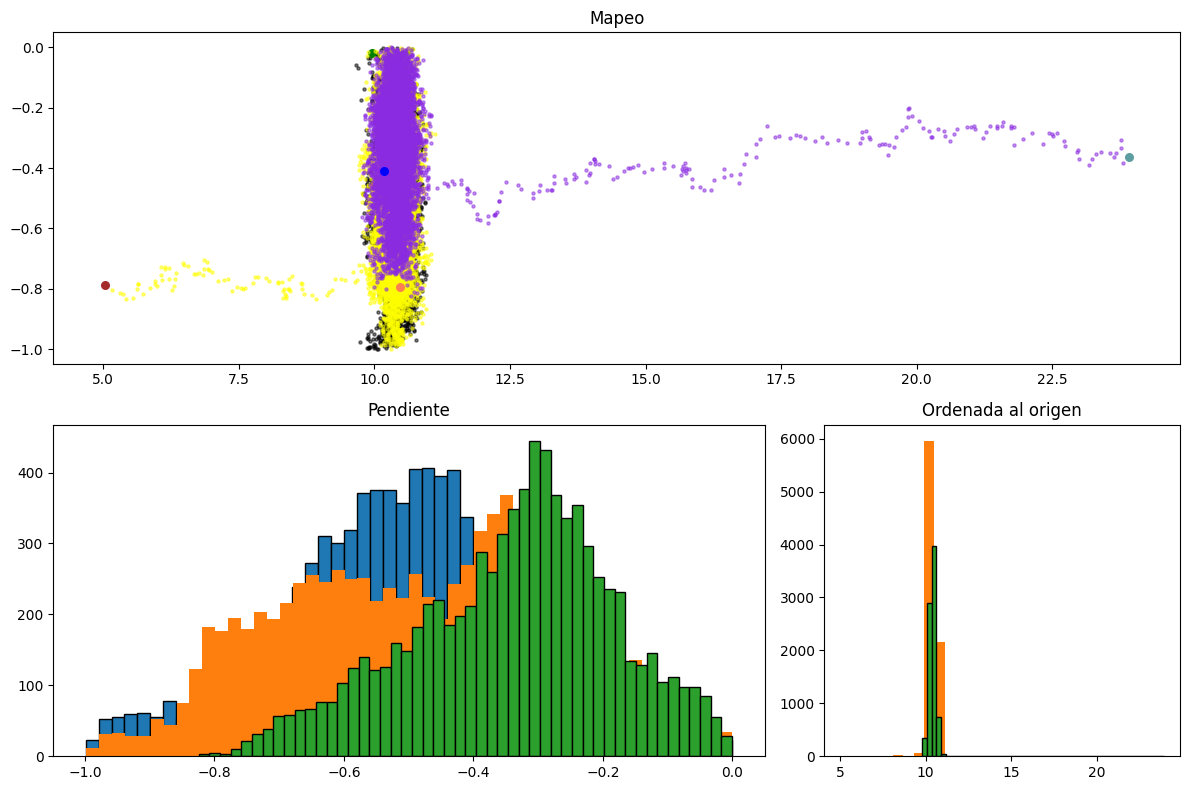

In [201]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])


# Subplot superior
ax1 = plt.subplot(gs[0, :])  # Toma todo el ancho
#ax1.plot(minimos,minimos_y)
ax1.scatter(resultados[:, 0], resultados[:,1], 5, alpha=0.5, color="black")
ax1.scatter(resultados[:, 0][-1], resultados[:, 1][-1], 30, "r")
ax1.scatter(resultados[:, 0][0], resultados[:, 1][0], 30, "g")
ax1.set_title('Mapeo')

# Subplots inferiores
ax2 = plt.subplot(gs[1, 0])
ax2.hist(resultados[:,1], bins=50, edgecolor='black')
ax2.set_title('Pendiente')

ax3 = plt.subplot(gs[1, 1])
ax3.hist(resultados[:,0], bins=50, edgecolor='black')
ax3.set_title('Ordenada al origen')


# Subplot superior
ax1 = plt.subplot(gs[0, :])  # Toma todo el ancho
ax1.scatter(resultados2[:, 0], resultados2[:,1], 5, alpha=0.5, color="yellow")
ax1.scatter(resultados2[:, 0][-1], resultados2[:, 1][-1], 30, "#FF7F50")
ax1.scatter(resultados2[:, 0][0], resultados2[:, 1][0], 30, "brown")
ax1.scatter(10., -0.46, 30, color="orange")
ax1.set_title('Mapeo')

# Subplots inferiores
ax2 = plt.subplot(gs[1, 0])
ax2.hist(resultados2[:,1], bins=50)
ax2.set_title('Pendiente')

ax3 = plt.subplot(gs[1, 1])
ax3.hist(resultados2[:,0], bins=10)
ax3.set_title('Ordenada al origen')

ax1 = plt.subplot(gs[0, :])  # Toma todo el ancho
ax1.scatter(resultados3[:, 0], resultados3[:,1], 5, alpha=0.5, color="#8A2BE2")
ax1.scatter(resultados3[:, 0][-1], resultados3[:, 1][-1], 30, "#0000FF")
ax1.scatter(resultados3[:, 0][0], resultados3[:, 1][0], 30, "#5F9EA0")
ax1.set_title('Mapeo')

# Subplots inferiores
ax2 = plt.subplot(gs[1, 0])
ax2.hist(resultados3[:,1], bins=50, edgecolor='black')
ax2.set_title('Pendiente')

ax3 = plt.subplot(gs[1, 1])
ax3.hist(resultados3[:,0], bins=50, edgecolor='black')
ax3.set_title('Ordenada al origen')

plt.tight_layout()
plt.show()



[10.348643065284435, -0.5267298581017803, -0.5151726465997095]
[10.348643065284435, -0.5267298581017803, -0.5151726465997095, -0.3607677124579991]
Predicción: [10.348643065284435, -0.5267298581017803, -0.5151726465997095, -0.3607677124579991]


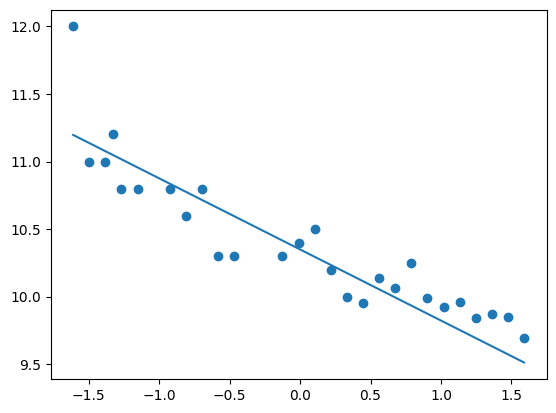

In [200]:
#Falta el burning (eliminar los datos que no están en la distribución que se ocupa)

prediccion = []

counts, bins = np.histogram(resultados[:, 0], bins=20)
mean_value = np.sum(bins[:-1] * counts) / np.sum(counts)
prediccion.append(mean_value)



print("Predicción:", prediccion)


In [197]:
Log_Posterior(datos_x, datos_y, [36.94, -0.01333], Modelo, theta_min, theta_max)
Log_Posterior(datos_x_norm, datos_y_norm, [36.94, -0.01333], Modelo, theta_min, theta_max)

-18434.786609931183

In [ ]:

prediccion = []

counts, bins = np.histogram(resultados[:, 0], bins=20)
mean_value = np.sum(bins[:-1] * counts) / np.sum(counts)
prediccion.append(mean_value)

counts, bins = np.histogram(resultados[:, 1], bins=20)
mean_value = np.sum(bins[:-1] * counts) / np.sum(counts)
prediccion.append(mean_value)

print("Predicción:", prediccion)

Predicción: [36.949283506752096, -0.007264424274968987]


La predicción hecha por el método Monte Carlo para el modelo lineal es: 36.94 ordenada al origen y -0.00726.

La predicción obtenida por el método de mínimos cuadrados obtenida anteriormente es: 36.41 ordenada al origen y -0.01333 pendiente

#Criterios de convergencia

* Check for low/high acceptamce rates
* Run long chains
* Look at the sequence of chains
* Run several chains, initialized in different points of the parameter space
* Different segments of the chain give the same result

------------
Mejor predicción hecha registrada, también es la que reporté antes de seguir haciendo pruebas

In [ ]:
theta_inicial = [36, -0.03]
theta_propuesta = [38, -0.03]
print("Likelihood inicial: ", Log_Likelihood(datos_x, datos_y, theta_inicial, Modelo))
print("Likelihood propuesto: ", Log_Likelihood(datos_x, datos_y, theta_propuesta, Modelo))

Likelihood inicial:  29343.63379999999
Likelihood propuesto:  25891.873799999998


33.833833833833836 1.4236058425993539
36.43643643643644 1.371017489593324
49.44944944944945 2.8341227984741484
36.53653653653654 1.3617984239540004
[33.833833833833836, 36.43643643643644, 49.44944944944945]


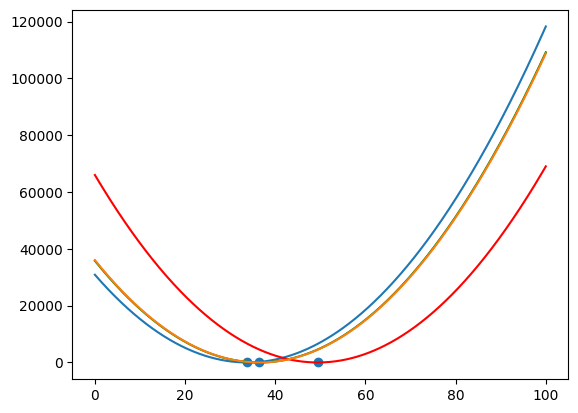

In [ ]:
minimos = []
minimos_y = []
x = np.linspace(0, 100, 1000)
w=-0.012
coso = []
for i in x:
  theta = [i, w]
  likelihood = Log_Likelihood(datos_x, datos_y, theta, Modelo)
  coso.append(likelihood)

plt.plot(x, coso)
coso = np.array(coso)
print(x[np.argmin(coso)], np.min(coso))
minimos_y.append(np.min(coso))
minimos.append(x[np.argmin(coso)])

w=-0.01333
coso = []
for i in x:
  theta = [i, w]
  #theta = [i, -1]
  likelihood = Log_Likelihood(datos_x, datos_y, theta, Modelo)
  coso.append(likelihood)

plt.plot(x, coso, "g")
coso = np.array(coso)

print(x[np.argmin(coso)], np.min(coso))
minimos_y.append(np.min(coso))
minimos.append(x[np.argmin(coso)])

w=-0.02
coso = []
for i in x:
  theta = [i, w]
  #theta = [i, -1]
  likelihood = Log_Likelihood(datos_x, datos_y, theta, Modelo)
  coso.append(likelihood)

plt.plot(x, coso, "r")
coso = np.array(coso)
print(x[np.argmin(coso)], np.min(coso))
minimos_y.append(np.min(coso))
minimos.append(x[np.argmin(coso)])

w=-0.013386640013207362
coso = []
for i in x:
  theta = [i, w]
  #theta = [i, -1]
  likelihood = Log_Likelihood(datos_x, datos_y, theta, Modelo)
  coso.append(likelihood)

plt.plot(x, coso)
coso = np.array(coso)
print(x[np.argmin(coso)], np.min(coso))
"""minimos_y.append(np.min(coso))
minimos.append(x[np.argmin(coso)])"""

print(minimos)
minimos = np.array(minimos)
minimos_y = np.array(minimos_y)
plt.scatter(minimos, minimos_y)
#plt.ylim(0, 2000)
#w e [-0.05, 0]

29.929929929929934


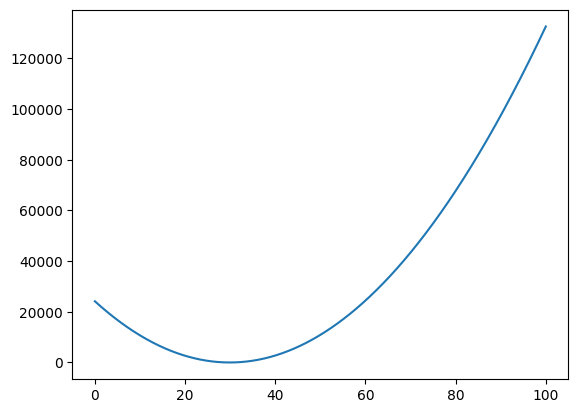

In [ ]:
b = np.linspace(0, 100, 1000)
w = -0.01
theta_min = [0, -10]
theta_max = [100, 0]
posteriors = []
for i in b:
  #theta = [i, -0.01333]
  theta = [i, w]
  post = Log_Posterior(datos_x, datos_y, theta, Modelo, theta_min, theta_max)
  posteriors.append(post)
#def Log_Posterior(x, y, theta, modelo, theta_min, theta_max):
plt.plot(b, posteriors)
posteriors = np.array(posteriors)
print(b[np.argmin(posteriors)])

-----------------
Intento de animación de cómo varia el likelihood respecto a los pesos de theta

In [203]:
from matplotlib.animation import FuncAnimation

In [204]:
def funcion(b):
  w_long = np.linspace(-1, 0, 100)
  #print(w_long)
  print("b = :", b)
  likelihood = []
  for w in w_long:
    theta = [b, w]
    l = Log_Likelihood(datos_x, datos_y, theta, Modelo)
    likelihood.append(l)

  print(likelihood)
  frame, = plt.plot(w_long, likelihood)
  return (frame,)

b = : 30.0
[-50446183.10870001, -49421979.0013477, -48408278.95888672, -47405082.98131708, -46412391.06863877, -45430203.22085182, -44458519.43795621, -43497339.71995191, -42546664.06683897, -41606492.47861735, -40676824.955287084, -39757661.496848136, -38849002.10330055, -37950846.7746443, -37063195.51087937, -36186048.31200579, -35319405.17802353, -34463266.10893263, -33617631.10473305, -32782500.16542482, -31957873.29100793, -31143750.481482364, -30340131.73684815, -29547017.05710526, -28764406.44225372, -27992299.892293505, -27230697.407224633, -26479598.98704711, -25739004.63176091, -25008914.341366053, -24289328.115862537, -23580245.95525035, -22881667.8595295, -22193593.828699995, -21516023.862761833, -20848957.961714998, -20192396.125559505, -19546338.35429535, -18910784.647922527, -18285735.00644104, -17671189.4298509, -17067147.918152098, -16473610.471344622, -15890577.089428497, -15318047.772403704, -14756022.520270245, -14204501.333028127, -13663484.210677346, -13132971.153

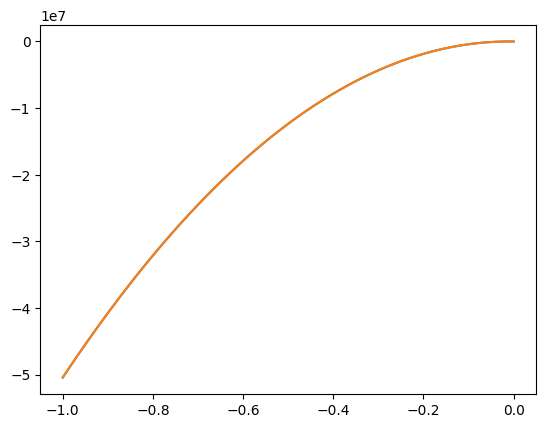

In [205]:
fig, ax = plt.subplots()
b_long = np.linspace(30, 42, 100)
animacion = FuncAnimation(fig, funcion, frames=b_long, blit=True)
plt.show()

In [ ]:
print(type(animacion))
print(np.shape(animacion))

<class 'matplotlib.animation.FuncAnimation'>
()


0.0 2921.7374000000004
-0.04604604604604605 39.02038340382432
-0.013013013013013013 11.216538622105547


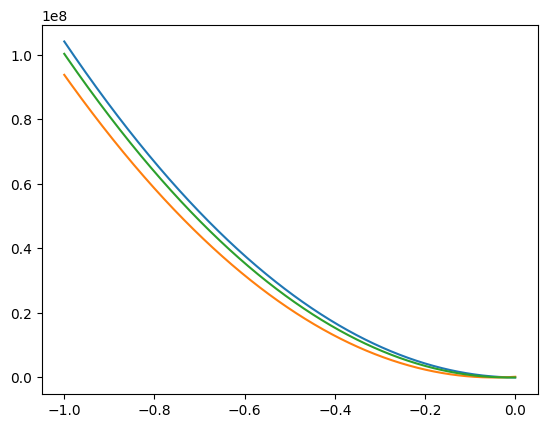

In [ ]:
b = 0
w_long = np.linspace(0, -1, 1000)
#b = np.linspace(0, 100, 1000)35.65566923074046
likelihood = []
for w in w_long:
  theta = [b, w]
  l = Log_Likelihood(datos_x, datos_y, theta, Modelo)
  likelihood.append(l)
likelihood = np.array(likelihood)
print(w_long[np.argmin(likelihood)], np.min(likelihood))
frame, = plt.plot(w_long, likelihood)

b = 100
likelihood = []
for w in w_long:
  theta = [b, w]
  l = Log_Likelihood(datos_x, datos_y, theta, Modelo)
  likelihood.append(l)

likelihood = np.array(likelihood)
print(w_long[np.argmin(likelihood)], np.min(likelihood))
frame, = plt.plot(w_long, likelihood)

b = 36.4
likelihood = []
for w in w_long:
  theta = [b, w]
  l = Log_Likelihood(datos_x, datos_y, theta, Modelo)
  likelihood.append(l)

likelihood = np.array(likelihood)
print(w_long[np.argmin(likelihood)], np.min(likelihood))
frame, = plt.plot(w_long, likelihood)

w:  <class 'numpy.ndarray'> (100, 100)
b:  <class 'numpy.ndarray'> (100, 100)


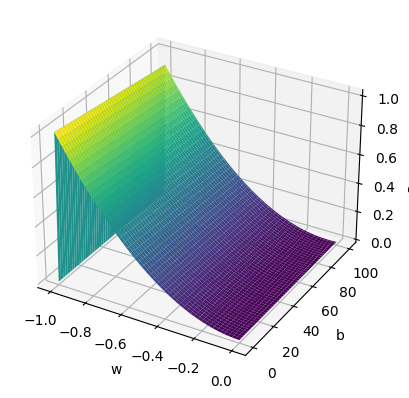

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Definir una cuadrícula tridimensional de puntos
w = np.linspace(0, -1, 100)
b = np.linspace(0, 100, 100)
W, B = np.meshgrid(w, b)
print("w: ", type(W), W.shape)
print("b: ", type(B), B.shape)
# Definir la función que representa la superficie (ejemplo: una paraboloide)
#Z = W**2 + B**2
#print("z: ", type(Z[0]), Z.shape)
theta_min = [0, -1]
theta_max = [100, 0]
P = np.zeros((100,100))
for i in range(100):
  for j in range(99):
    P[i, j] = Log_Posterior(datos_x, datos_y, [b[i], w[j]], Modelo, theta_min, theta_max)
# Crear una figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
ax.plot_surface(W, B, P, cmap='viridis')

# Etiquetas de los ejes
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('Posterior')

# Mostrar la gráfica en 3D
plt.show()


In [ ]:
P = np.zeros((100,100))
for i in range(100):
  for j in range(99):
    P[i, j] = Log_Posterior(datos_x, datos_y, [b[i], w[j]], Modelo, theta_min, theta_max)

In [ ]:
P = np.zeros((100, 100))

In [ ]:
print("p: ", type(P), P.shape)

p:  <class 'numpy.ndarray'> (100, 100)


In [ ]:
P[:, -1]print(posterior_propuesta, "-", posterior_inicial, "=", (posterior_propuesta - posterior_inicial) , "<", r, "¿?")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
counts, bins = np.histogram(resultados[:, 1], bins=20)
mean_value = np.sum(bins[:-1] * counts) / np.sum(counts)
prediccion.append(mean_value)
y = Modelo(datos_x_norm, prediccion)
plt.plot(datos_x_norm, y)
plt.scatter(datos_x_norm, datos_y)

counts, bins = np.histogram(resultados2[:, 1], bins=20)
mean_value = np.sum(bins[:-1] * counts) / np.sum(counts)
prediccion.append(mean_value)
print(prediccion)
counts, bins = np.histogram(resultados3[:, 1], bins=20)
mean_value = np.sum(bins[:-1] * counts) / np.sum(counts)
prediccion.append(mean_value)
print(prediccion)